# <font color=red> Project: Analyze A/B Test Results.</font>



## <font color=blue>Table of Contents </font>
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
##  <font color=blue>Introduction </font>


**A/B tests are very commonly performed by data analysts and data scientists**

**It is important that you get some practice working with the difficulties of these.**

> For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#  <font color=blue>Part I - Probability </font>

##  Loading Data and Libraries :

In [49]:
# Import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm;
#We are setting the seed to assure getting the same answers o
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# loading Data 
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


 ###  - Finding the number of rows in the dataset.

In [4]:
df.shape[0]

294478

### - Finding the number of unique users in the dataset.

In [5]:
len(df.user_id.unique())

290584

### - Finding the proportion of users converted.

In [6]:
str(round(df.converted.mean()*100))+'%'

'12.0%'

### - Finding the number of times the `new_page` and `treatment` don't match.

In [7]:
len(df.query('group == "treatment" and landing_page != "new_page"')) + len(df.query('group != "treatment" and landing_page == "new_page"'))


3893

### - Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [9]:
# Another way :
if df.isnull().sum().sum() > 0 :
    print('Null values found!')
else:
    print('No Null values found here please continue!')

No Null values found here please continue!


>For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.</br>


### Creating a new dataset `df2` that meets this specifications .

In [10]:
x=df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False]
df2=df.drop(x.index)
df2.shape[0]

290585

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### - Finding how many unique **user_id**s are in **df2**?

In [12]:
len(df2.user_id.unique())

290584

> So,There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2['user_id'].duplicated()]['user_id']

2893    773192
Name: user_id, dtype: int64

> What is the row information for the repeat **user_id**? 

In [14]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


> Removing **one** of the rows with a duplicate **user_id**.

In [15]:
df2.drop([2893],inplace=True)

In [16]:
#test
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0




### A. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

### B. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
control_con=df2[df2['group']=="control"]['converted'].mean()
control_con

0.1203863045004612

### C. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
treatment_con=df2[df2['group']=="treatment"]['converted'].mean()
treatment_con

0.11880806551510564

### D. What is the probability that an individual received the new page?

In [20]:
len(df2[df2['landing_page']=='new_page'])/df2.shape[0]

0.5000619442226688

### E. Do you think there is sufficient evidence to conclude that the new treatment page leads to more conversions?

In [21]:
#Finding if the new treatment page leads to more conversion
treatment_con - control_con

-0.0015782389853555567

### <font color=green>Interpretation </font> 
> **There is no sufficient evidence** to say that the new treatment page leads to more conversions.

>**Actually**, the probabilities show less conversion of treatment group than the control group.


<a id='ab_test'></a>
# <font color=blue>Part II - A/B Test</font>

>Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

>However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

>These questions are the difficult parts associated with A/B tests in general.  


**For now**, we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  we can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

>**The null hypotheses**
$$H_0:p_{old} \geq p_{new} $$

>**The alternative hypotheses**
$$H_1:p_{old} < p_{new} $$


**Assuming that under the null hypothesis** $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

>We will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

>We will perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>


### A. What is the **conversion rate** for $p_{new}$ under the null? 

In [22]:
# p_new = p_old = coversion_rate
p_new=df2.converted.mean()
p_new

0.11959708724499628

### B. What is the **conversion rate** for $p_{old}$ under the null?

In [23]:
# p_old = p_new = coversion_rate
p_old=df2.converted.mean()
p_old

0.11959708724499628

### C. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
n_new=len(df2[df2['group']=='treatment'])
n_new

145310

### D. What is $n_{old}$, the number of individuals in the control group?

In [25]:
n_old=len(df2[df2['group']=='control'])
n_old

145274

### E. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
new_page_converted = np.random.binomial(1, p_new, n_new)
len(new_page_converted)

145310

In [33]:
new_page_converted.mean()

0.12016378776409056

### F. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
old_page_converted = np.random.binomial(1, p_old, n_old)
len(old_page_converted)

145274

In [34]:
old_page_converted.mean()

0.11993199058331154

### G. Finding $p_{new}$ - $p_{old}$ for  simulated values from part (e) and (f).

In [37]:
(new_page_converted.mean() - old_page_converted.mean()).mean()


0.00023179718077902256

### H. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. 

In [39]:
p_diffs = []
for i in range(10000):
    new_page_con = np.random.binomial(n_new,p_new)
    old_page_con = np.random.binomial(n_old,p_old)
    diffs = new_page_con/n_new - old_page_con/n_old
    p_diffs.append(diffs)

### I. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected? 

(array([    4.,    63.,   340.,  1469.,  2781.,  2979.,  1757.,   510.,
           87.,    10.]),
 array([-0.0049781 , -0.0040035 , -0.00302891, -0.00205431, -0.00107971,
        -0.00010512,  0.00086948,  0.00184407,  0.00281867,  0.00379327,
         0.00476786]),
 <a list of 10 Patch objects>)

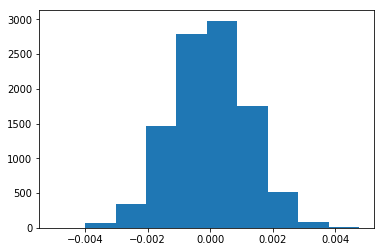

In [40]:
plt.hist(p_diffs)

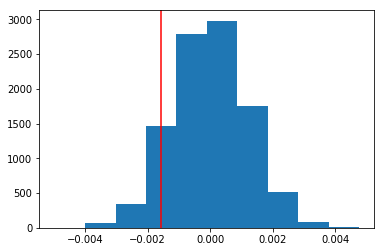

In [46]:
#calculate the actual difference
df_diff=treatment_con-control_con
#compare actual difference to the distribution mean
plt.hist(p_diffs);
plt.axvline(x=df_diff, c='red');

### J. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [48]:
df_diff=np.array(df_diff)
p_value = (p_diffs>df_diff).mean()
p_value

0.90580000000000005

### <font color=green>Interpretation </font> 
> **p-value is the probability of obtaining test results at least as extreme as the results actually observed.**
A very small p-value means that we need to raject the null hypothesis and accept the alternative one.

>We got a p-value with **0.90580000000000005** and it's more than **0.05** so, we can not reject the null hypothesis.

>**We fail to reject the null hypothesis.**

>**The old page is better.**


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [52]:
convert_old = len(df2.query("landing_page == 'old_page' and converted == 1 "))
convert_new = len(df2.query("landing_page == 'new_page' and converted == 1 "))
n_old = len(df2.query("landing_page == 'old_page'"))
n_new = len(df2.query("landing_page == 'new_page'"))
print(" The number of conversions for Old Page is:",convert_old)
print(" The number of conversions for New Page is:",convert_new)
print("=============================================================")
print(" The number of rows of Old Page is:",n_old)
print(" The number of rows of New Page is:",n_new)

 The number of conversions for Old Page is: 17489
 The number of conversions for New Page is: 17264
 The number of rows of Old Page is: 145274
 The number of rows of New Page is: 145310


### M. Now we will use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [53]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

### <font color=green>Interpretation </font> 
>**Considerng** the critical value is **Z = 1.645** .

>**And** we got a **Z = 1.311** which is less than the critical value,So we **fail to reject the null hypothesis** that supports the result we got from **p-value**.

<a id='regression'></a>
### <font color=blue>Part III - A regression approach </font>

**In this final part**, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

### A. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>**We should use logistic regression** since logistic regression is used for predict categorical data with only 2 outcomes which are 0 if user don't convert and 1 if user converts.

### B.  using **statsmodels** to fit the regression model we specified in part **A.** to see if there is a significant difference in conversion based on which page a customer receives. 

In [54]:
#Creating intercept column and dummies variables..
df2['intercept']=1
df2[['ab_page','new_page']]=pd.get_dummies(df2['landing_page'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,new_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1


### C. Using  **statsmodels** to instantiate our regression model on the two columns we created in part b., then fitting the model using the two columns we created in part **b.** to predict whether or not an individual converts. 

In [55]:
logit = sm.Logit(df2['converted'],df2[['intercept','ab_page']])

### D. Providing the summary of our model below.

In [57]:
results = logit.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-07 12:15 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

### E. What is the p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?

### Answer
>The **p-value** for **ab_page** is 0.19
### Why does it differ from the value we found in Part II
> Cause the null and alternative hypotheses **are not** the same in the two parts<br>
### **In Part II** the null and alternative hypotheses are:<br>


>**The null hypotheses**
$$H_0:p_{old} \geq p_{new} $$

>**The alternative hypotheses**
$$H_1:p_{old} < p_{new} $$

### Here the null and alternative hypotheses are:

>**The null hypotheses**
$$H_0:p_{old} = p_{new} $$

>**The alternative hypotheses**
$$H_1:p_{old} != p_{new} $$

### F.  Discussing why it is a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into our regression model?

### Advantages:
>We should consider other factors that **might affect** the predection of the convertion like age group and gender and so on as this way we can find more influnicng factors.
### Disadvantages:
> Sometimes we can add more factors that **are not necessary** and might lead to misleading results.



### G. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. we will need to read in the **countries.csv** dataset and merge together our datasets on the appropriate rows. 

In [58]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,new_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0


### H. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [59]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [60]:
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [61]:
df_new[['CA','UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,new_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0,1,0


In [62]:
LOG= sm.Logit(df_new['converted'], df_new[['intercept','ab_page','CA', 'UK']])
results = LOG.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-07 12:43 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

In [63]:
np.exp(results.params)

intercept    0.136795
ab_page      0.985168
CA           0.960062
UK           1.009932
dtype: float64

In [64]:
np.exp(-0.0149),np.exp(-0.0408),np.exp(0.0099)

(0.9852104557227469, 0.96002111497165088, 1.0099491671175422)

### <font color=green>Interpretation </font> 
> **It's not appear that country has an impact on conversions**.

<a id='conclusions'></a>
# <font color=red>Conclusion </font> 
>No significant effect of change the page to the new page.<br>
No significant different in interactions between countries.<br>

## <font color=green>**The E-Commerce Company should keep the old page.** </font> 



In [65]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0